Define the device:

In [1]:
import os
import torch
import warnings
warnings.filterwarnings('ignore')

gpu_list = [0]
gpu_list_str = ','.join(map(str, gpu_list))
os.environ.setdefault("CUDA_VISIBLE_DEVICES", gpu_list_str)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import random
import numpy as np
def setup_seed(seed):
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = True

setup_seed(3407)

Define the `Hist2Cell` model:

In [3]:
from torch.nn import Linear
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATv2Conv, LayerNorm
import sys,os
sys.path.append(os.path.dirname(os.getcwd()))
from model.ViT import Mlp, VisionTransformer


class Hist2Cell(nn.Module):
    def __init__(self, cell_dim=80, vit_depth=3):
        super(Hist2Cell, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18 = torch.nn.Sequential(*list(self.resnet18.children())[:-1])
        
        self.embed_dim = 32 * 8
        self.head = 8
        self.dropout = 0.3
        
        self.conv1 = GATv2Conv(in_channels=512, out_channels=int(self.embed_dim/self.head), heads=self.head)
        self.norm1 = LayerNorm(in_channels=self.embed_dim)
        
        self.cell_transformer = VisionTransformer(num_classes=cell_dim, embed_dim=self.embed_dim, depth=vit_depth,
                                                  mlp_head=True, drop_rate=self.dropout, attn_drop_rate=self.dropout)
        self.spot_fc = Linear(in_features=512, out_features=256)
        self.spot_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.local_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
        self.fused_head = Mlp(in_features=256, hidden_features=512*2, out_features=cell_dim)
    
    
    def forward(self, x, edge_index):
        x_spot = self.resnet18(x)
        x_spot = x_spot.squeeze()
        
        x_local = self.conv1(x=x_spot, edge_index=edge_index)
        x_local = self.norm1(x_local)
        
        x_local = x_local.unsqueeze(0)
        
        x_cell = x_local
        
        x_spot = self.spot_fc(x_spot)
        cell_predication_spot = self.spot_head(x_spot)
        x_local = x_local.squeeze(0)
        cell_prediction_local = self.local_head(x_local)
        cell_prediction_global, x_global = self.cell_transformer(x_cell)
        cell_prediction_global = cell_prediction_global.squeeze()
        x_global = x_global.squeeze()
        cell_prediction_fused = self.fused_head((x_spot+x_local+x_global)/3.0)
        cell_prediction = (cell_predication_spot + cell_prediction_local + cell_prediction_global + cell_prediction_fused) / 4.0
            
        cell_prediction = torch.relu(cell_prediction)
        
        return cell_prediction

Load the checkpoint weights in the Leave-A50-out experiments for human lung cell2location dataset:

In [15]:
case = "A50"

model = Hist2Cell(vit_depth=3)
# checkpoint = torch.load("../model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
checkpoint = torch.load("../model_weights/Breast_cancer_epoch3.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for Hist2Cell:
	size mismatch for cell_transformer.head.fc2.weight: copying a param with shape torch.Size([39, 128]) from checkpoint, the shape in current model is torch.Size([80, 128]).
	size mismatch for cell_transformer.head.fc2.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for spot_head.fc2.weight: copying a param with shape torch.Size([39, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
	size mismatch for spot_head.fc2.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for local_head.fc2.weight: copying a param with shape torch.Size([39, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
	size mismatch for local_head.fc2.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for fused_head.fc2.weight: copying a param with shape torch.Size([39, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
	size mismatch for fused_head.fc2.bias: copying a param with shape torch.Size([39]) from checkpoint, the shape in current model is torch.Size([80]).

Load test split file, there are 2 slides from donor A50 in humanlung cell2location dataset: 
- WSA_LngSP9258463
- WSA_LngSP9258467

In [16]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_H.txt").read().split('\n')
test_slides

['H1', 'H2', 'H3']

Load and create the `Dataloader` for the processed data of each slide, save the predictions and calculate the pearson R for 80 fine-grained cell types:

In [17]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../example_data/humanlung_cell2location", item+'.pt')))
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)
        
        center_num = len(graph.input_id)
        
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
all = []
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        if (slide_no == 0):
         all.append(r)
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 108/108 [00:44<00:00,  2.43it/s]

slide H1 has PCC:0.561975
slide H2 has PCC:0.556112
slide H3 has PCC:0.527155


In [12]:
len(all)
def sort_numbers_with_indices(numbers):
    indexed_numbers = list(enumerate(numbers))
    sorted_indexed_numbers = sorted(indexed_numbers, key=lambda x: x[1])
    return sorted_indexed_numbers
sorted_indexed_numbers = sort_numbers_with_indices(all)

In [13]:
sorted_indexed_numbers

[(9, 0.02524967370277644),
 (37, 0.1201058089813279),
 (24, 0.13294268491464623),
 (3, 0.17268727256052196),
 (4, 0.17602389653367478),
 (18, 0.2860323856674492),
 (17, 0.29809224232876014),
 (10, 0.39067166857700253),
 (27, 0.39368851359238993),
 (31, 0.40476085690979285),
 (34, 0.40875232332063843),
 (16, 0.4509672884657561),
 (23, 0.4567634197026636),
 (38, 0.479412693851797),
 (8, 0.5130547349531925),
 (5, 0.5686774088179267),
 (14, 0.5908449599928938),
 (25, 0.6119929661866844),
 (12, 0.626889318158246),
 (21, 0.6405397277469899),
 (33, 0.6811266403460845),
 (30, 0.71014067783741),
 (19, 0.7137836389997932),
 (32, 0.7158273943577365),
 (20, 0.715833979652477),
 (13, 0.7338791619712515),
 (26, 0.7349779352612978),
 (2, 0.7362476787738667),
 (22, 0.7474989722821959),
 (29, 0.7499369919305943),
 (0, 0.7539108345949596),
 (28, 0.7599584165751396),
 (36, 0.7612035627941771),
 (6, 0.7652166339676958),
 (11, 0.7654080561158016),
 (1, 0.7668907120411385),
 (15, 0.7809909177652182),
 (35, 

In [26]:
import joblib
cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types_brast_cancer.pkl")
cell_types[21]

'luminal epithelial cell of mammary gland'

In [7]:
Predictions.keys()

dict_keys(['WSA_LngSP9258463', 'WSA_LngSP9258467'])

Under the prediction of each slide, we have the labels and predictions for the 80 fine-grained cell types of each spot, and the spatial coordinate of each spot:

In [8]:
Predictions['WSA_LngSP9258467'].keys()

dict_keys(['cell_abundance_predictions', 'cell_abundance_labels', 'coords'])

Visualize the predictions of `Hist2Cell` in `Fig 3b`, `Fig 3a` and `Supp Fig 4`.

In [4]:
import matplotlib.pyplot as plt
from PIL import Image


def plot_cell_abundance(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=105):
    fig, ax = plt.subplots()
    ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    sc = ax.scatter(img.size[0] - (X), img.size[1] - (Y),
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap,vmax = 0.5)

    ax.set_xlim(img.size[0] - (min(X)-50), img.size[0] - (max(X)+50))
    ax.set_ylim(img.size[1] - (min(Y)-50), img.size[1] - (max(Y)+50))
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(sc, ax=ax)

    cbar.ax.tick_params(labelsize=14)
    
    ax.set_title(cell_name, fontsize=16)  
    
    plt.show()

In [34]:
import matplotlib.pyplot as plt
from PIL import Image


def plot_cell_abundance_label(img, X, Y, cell_abundance, cell_name, cmap='viridis', s=105):
    fig, ax = plt.subplots()
    ax.imshow(img.transpose(Image.FLIP_TOP_BOTTOM).transpose(Image.FLIP_LEFT_RIGHT))

    sc = ax.scatter(img.size[0] - (X), img.size[1] - (Y),
                    c=cell_abundance,
                    s=s, alpha=0.80, cmap=cmap)

    ax.set_xlim(img.size[0] - (min(X)-50), img.size[0] - (max(X)+50))
    ax.set_ylim(img.size[1] - (min(Y)-50), img.size[1] - (max(Y)+50))
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(sc, ax=ax)

    cbar.ax.tick_params(labelsize=14)
    
    ax.set_title(cell_name + "_label", fontsize=16)  
    
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

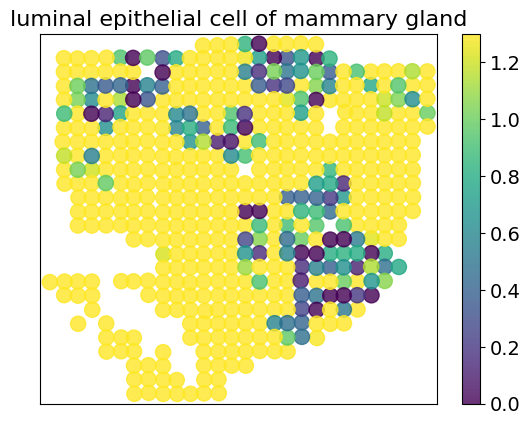

 33%|███▎      | 1/3 [00:00<00:00,  6.23it/s]

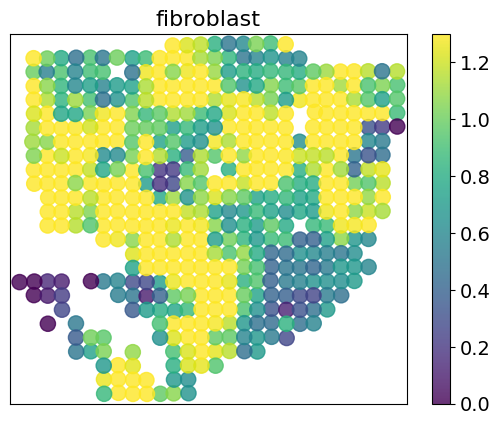

 67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

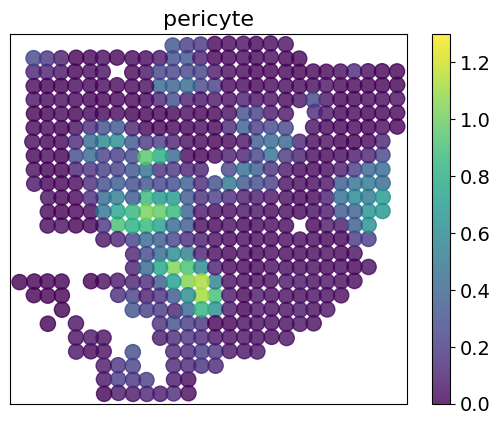

100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


In [59]:
import joblib
from tqdm import tqdm


slide = "H3"

cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types_brast_cancer.pkl")

# 指定要可视化的细胞类型名称列表
visualize_cell_names = ['luminal epithelial cell of mammary gland', 'fibroblast', 'pericyte']

#np.clip 限制值在指定范围中
hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_predictions'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)


# 遍历可视化的细胞类型并绘制丰度图
for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    # 绘制当前细胞类型的丰度图
    plot_cell_abundance(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis', s= 120)

Follow the same steps, we visualize the cell abundance predictions in `Fig 2`:

In [16]:
case = "A50"

model = Hist2Cell(vit_depth=3)
checkpoint = torch.load("../model_weights/humanlung_cell2location_leave_"+case+"_out.pth")
model.load_state_dict(checkpoint)
model = model.to(device)

In [17]:
test_slides = open("../train_test_splits/humanlung_cell2location/test_leave_"+case+".txt").read().split('\n')
test_slides

['WSA_LngSP9258463', 'WSA_LngSP9258467']

In [18]:
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import torch_geometric
torch_geometric.typing.WITH_PYG_LIB = False
from torch_geometric.data import Batch
import numpy as np
from scipy.stats import pearsonr


hop = 2
subgraph_bs = 16
test_graph_list = list()
for item in test_slides:
    test_graph_list.append(torch.load(os.path.join("../example_data/humanlung_cell2location", item+'.pt')))
# 将数据列表转换为Batch对象，以便进行批处理
test_dataset = Batch.from_data_list(test_graph_list)

test_loader = NeighborLoader(
    test_dataset,
    num_neighbors=[-1]*hop,
    batch_size=subgraph_bs,
    directed=False,
    input_nodes=None,
    shuffle=False,
    num_workers=2,
)

with torch.no_grad():
    model.eval()
    test_cell_pred_array = []
    test_cell_label_array = []
    test_cell_pos_array = []
    for graph in tqdm(test_loader):
        x = graph.x.to(device)
        y = graph.y.to(device)
        pos = graph.pos.to(device)
        edge_index = graph.edge_index.to(device)
        cell_label = y[:, 250:]
        cell_pred = model(x=x, edge_index=edge_index)

        center_num = len(graph.input_id)
        center_cell_label = cell_label[:center_num, :]
        center_cell_pred = cell_pred[:center_num, :]
        center_cell_pos = pos[:center_num, :]
        
        test_cell_label_array.append(center_cell_label.squeeze().cpu().detach().numpy())
        test_cell_pred_array.append(center_cell_pred.squeeze().cpu().detach().numpy())
        test_cell_pos_array.append(center_cell_pos.squeeze().cpu().detach().numpy())
        

    if len(test_cell_pred_array[-1].shape) == 1:
        test_cell_pred_array[-1] = np.expand_dims(test_cell_pred_array[-1], axis=0)
    test_cell_pred_array = np.concatenate(test_cell_pred_array)
    if len(test_cell_label_array[-1].shape) == 1:
        test_cell_label_array[-1] = np.expand_dims(test_cell_label_array[-1], axis=0)
    test_cell_label_array = np.concatenate(test_cell_label_array)
    if len(test_cell_pos_array[-1].shape) == 1:
        test_cell_pos_array[-1] = np.expand_dims(test_cell_pos_array[-1], axis=0)
    test_cell_pos_array = np.concatenate(test_cell_pos_array)
    

Predictions = dict()
R_all = []
for slide_no in range(len(test_slides)):
    indices = np.where(test_dataset.batch.numpy() == slide_no)
    test_cell_pred_array_sub = test_cell_pred_array[indices]
    test_cell_label_array_sub = test_cell_label_array[indices]
    test_cell_pos_arraay_sub = test_cell_pos_array[indices]
    
    test_cell_abundance_all_pearson_average = 0.0
    test_cell_pearson_list = []
    R = []
    for i in range(test_cell_pred_array_sub.shape[1]):
        r, p = pearsonr(test_cell_pred_array_sub[:, i], test_cell_label_array_sub[:, i])
        R.append(r)
        test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average + r
        test_cell_pearson_list.append(r)
    test_cell_abundance_all_pearson_average = test_cell_abundance_all_pearson_average / test_cell_pred_array_sub.shape[1]
    
    Predictions[test_slides[slide_no]] = {
        'cell_abundance_predictions': test_cell_pred_array_sub,
        'cell_abundance_labels': test_cell_label_array_sub,
        'coords': test_cell_pos_arraay_sub,
    }
    R_all.append(R)
    
    print("slide %s has PCC:%f" % (test_slides[slide_no], test_cell_abundance_all_pearson_average)) 

100%|██████████| 51/51 [00:20<00:00,  2.46it/s]

slide WSA_LngSP9258463 has PCC:0.283833
slide WSA_LngSP9258467 has PCC:0.367455


In [19]:
print(R_all)
def sort_numbers_with_indices(numbers):
    indexed_numbers = list(enumerate(numbers))
    sorted_indexed_numbers = sorted(indexed_numbers, key=lambda x: x[1])
    sorted_dict = {i: num for i, num in sorted_indexed_numbers}
    return sorted_dict
sorted_indexed_numbers_H1 = sort_numbers_with_indices(R_all[0])
sorted_indexed_numbers_H2 = sort_numbers_with_indices(R_all[1])
print(sorted_indexed_numbers_H1)

[[-0.03764494535711993, 0.05706903673126276, 0.2690597439574613, 0.6542945839838562, 0.005298471518138707, 0.050807815957375005, 0.2553944574878363, 0.6386614993922173, 0.6858504690880802, 0.6811564704701206, 0.1407983807790961, 0.6804844342823387, 0.14327033864465086, 0.6674111755355978, 0.6658136267469335, 0.2472932761486687, 0.7904808240420846, 0.20136549574012466, 0.3788680654754269, 0.4652250339618031, 0.5276400974050972, 0.5601178384061667, 0.40708887063186294, 0.5197317038320773, -0.03345632768989653, 0.11842435213660654, 0.13885702334779176, -0.020495970218711277, -0.03549718040159315, 0.015829660445111828, 0.2377858516256708, 0.4969134404199849, 0.2624826395964933, 0.014942188531539665, 0.21824289989620738, 0.2194343234823849, 0.2835154951801788, 0.10159304164858539, 0.6132853691063972, 0.6697347354132112, 0.5594438304587616, -0.0782439108581942, 0.11586243878401992, 0.21737213031813152, 0.166719672704272, 0.025326958405461283, 0.06271524335681124, 0.12636045933286286, 0.00616

In [20]:
visualize_cell_names = ['gdT', 'CD4_EM_Effector', 'CD8_EM']

In [21]:
import joblib
cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")

for i in range(len(visualize_cell_names)):
 cell_idx = cell_types.index(visualize_cell_names[i])
 print(visualize_cell_names[i])
 print(sorted_indexed_numbers_H1[cell_idx])
 print(sorted_indexed_numbers_H2[cell_idx])

gdT
0.6191974899479802
0.5249004321437161
CD4_EM_Effector
0.6858504690880802
0.6215384377016816
CD8_EM
0.6804844342823387
0.6641120438264985


  0%|          | 0/3 [00:00<?, ?it/s]

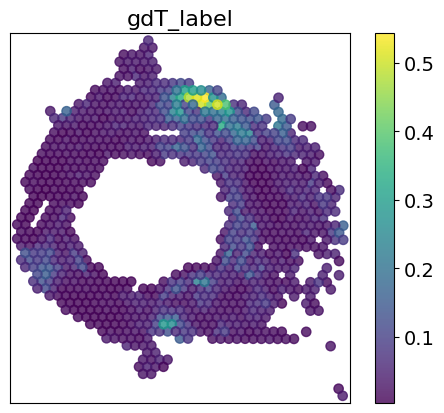

 33%|███▎      | 1/3 [00:00<00:00,  7.21it/s]

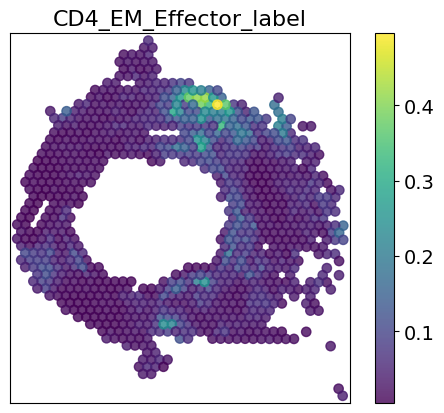

 67%|██████▋   | 2/3 [00:00<00:00,  7.74it/s]

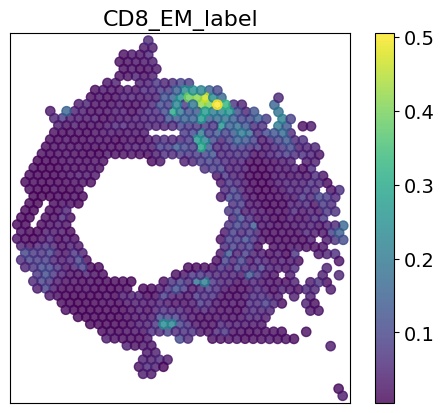

100%|██████████| 3/3 [00:00<00:00,  7.45it/s]


In [35]:
import joblib
from tqdm import tqdm


slide = "WSA_LngSP10193348"

cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types.pkl")
visualize_cell_names = ['gdT', 'CD4_EM_Effector', 'CD8_EM']


hist2cell_abundances = np.clip(Predictions[slide]['cell_abundance_labels'], a_min=0, a_max=None)
coordinates = Predictions[slide]['coords']
X = coordinates[:, 0] / 4
Y = coordinates[:, 1] / 4

jpg_path = '../example_data/humanlung_cell2location/'+slide+'_low_res.jpg'
img = Image.open(jpg_path)


for i in tqdm(range(len(visualize_cell_names))):
    cell_idx = cell_types.index(visualize_cell_names[i])
    plot_cell_abundance_label(img, X, Y, hist2cell_abundances[:, cell_idx], cell_types[cell_idx], cmap='viridis', s=45)

In [71]:
cell_types = joblib.load("../example_data/humanlung_cell2location/cell_types_brast_cancer.pkl")
print(cell_types)

['CD4-positive helper T cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta memory T cell', 'IgA plasma cell', 'IgG plasma cell', 'proliferating T cell', 'activated CD4-positive, alpha-beta T cell', 'activated CD8-positive, alpha-beta T cell', 'alternatively activated macrophage', 'basal cell', 'capillary endothelial cell', 'class switched memory B cell', 'classical monocyte', 'conventional dendritic cell', 'effector memory CD4-positive, alpha-beta T cell', 'effector memory CD8-positive, alpha-beta T cell', 'endothelial cell of artery', 'endothelial cell of lymphatic vessel', 'fibroblast', 'gamma-delta T cell', 'inflammatory macrophage', 'luminal epithelial cell of mammary gland', 'lymphocyte', 'macrophage', 'mammary gland epithelial cell', 'mast cell', 'mature NK T cell', 'proliferating myeloid cell', 'myeloid dendritic cell', 'naive B cell', 'natural killer cell', 'neutrophil', 'non-classical monocyte', 'pericyte', 'plasmacytoid dendritic cell', 'regulatory T cell', '